# Feature Analysis

This framework is used to analyse the audio signals (spoken words), usch that good features can be extracted to cluster them. 

# Imports

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm
# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
import pygsp

%matplotlib inline

plt.rcParams['figure.figsize'] = (17, 5)
pygsp.plotting.BACKEND = 'matplotlib'

2018-01-07 10:13:58,177:[WARNING](pygsp.graphs.nngraphs.nngraph.<module>): Cannot import pyflann (used for faster kNN computations): Traceback (most recent call last):
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pygsp\graphs\nngraphs\nngraph.py", line 14, in <module>
    import pyflann as pfl
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\__init__.py", line 27, in <module>
    from pyflann.index import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\index.py", line 27, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\bindings\__init__.py", line 30, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\bindings\flann_ctypes.py", line 171, in <module>
    raise ImportError('Cannot load dynamic library. Did you compile FLANN?')
ImportError: Cannot load dynamic library. Did you compile FLANN?



## 1. Import the Data
----
Use `N` random samples for each word.

In [2]:
N = 2

train_audio_path = '../Data/train/audio'
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()

path = []
word = []
speaker = []
iteration = []

for direct in dirs:
    if not direct.startswith('_'):
        # Random selection of N files per folder 
        list_files = os.listdir(join(train_audio_path, direct))
        wave_selected  = list(np.random.choice([ f for f in list_files if f.endswith('.wav')],N,replace=False))
        
        # Extraction of file informations for dataframe
        word.extend(list(np.repeat(direct,N,axis=0)))
        speaker.extend([wave_selected[f].split('.')[0].split('_')[0] for f in range(N) ])
        iteration.extend([wave_selected[f].split('.')[0].split('_')[-1] for f in range(N) ])
        path.extend([train_audio_path + '/' + direct + '/' + wave_selected[f] for f in range(N)])

Initialize the dataframe of the original data

In [3]:
features_og = pd.DataFrame({('info','word',''): word,
                            ('info','speaker',''): speaker,
                            ('info','iteration',''): iteration,
                            ('info','path',''): path})
index_og = [('info','word',''),('info','speaker',''),('info','iteration','')]
#features_og.set_index(index_og,inplace=True)
features_og.head()

info                                                                
  iteration                                            path   speaker  word
                                                                           
0         0   ../Data/train/audio/bed/e7117d00_nohash_0.wav  e7117d00   bed
1         0   ../Data/train/audio/bed/c6ee87a7_nohash_0.wav  c6ee87a7   bed
2         2  ../Data/train/audio/bird/659b7fae_nohash_2.wav  659b7fae  bird
3         0  ../Data/train/audio/bird/9637f43f_nohash_0.wav  9637f43f  bird
4         0   ../Data/train/audio/cat/71f6fed7_nohash_0.wav  71f6fed7   cat

## 2. Features Extraction
----
### 2.1 MFCC
A classical but reliable set of features

In [4]:
N_MFCC = 20

def compute_mfcc(filepath):
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
    return librosa.feature.mfcc(y=audio,sr=sampling_rate)

In [5]:
stat_name= ['mean','std','skew','kurtosis','median']
col_names = [('mfcc',stat_name[i],j) for i in range(len(stat_name))  for j in range(N_MFCC)]
features_mfcc =pd.DataFrame(columns=pd.MultiIndex.from_tuples(col_names),index=features_og.index)
# sorting the columns in order to improve index performances (see lexsort errors)
features_mfcc.sort_index(axis=1,inplace=True,sort_remaining=True)

# MFCC FEATURES :
for w in tqdm(range(len(features_og)),total=len(features_og),unit='waves'):
    mfcc = compute_mfcc(features_og[('info','path')].iloc[w])
    features_mfcc.loc[w, ('mfcc', 'mean')] = np.mean(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'std')] = np.std(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'skew')] = scipy.stats.skew(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'kurtosis')] = scipy.stats.kurtosis(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'median')] = np.median(mfcc,axis=1)
    
features_og = features_og.merge(features_mfcc,left_index=True,right_index=True)
features_og.head()

100%|██████████| 60/60 [00:02<00:00, 21.73waves/s]


info                                                                  \
  iteration                                            path   speaker  word   
                                                                              
0         0   ../Data/train/audio/bed/e7117d00_nohash_0.wav  e7117d00   bed   
1         0   ../Data/train/audio/bed/c6ee87a7_nohash_0.wav  c6ee87a7   bed   
2         2  ../Data/train/audio/bird/659b7fae_nohash_2.wav  659b7fae  bird   
3         0  ../Data/train/audio/bird/9637f43f_nohash_0.wav  9637f43f  bird   
4         0   ../Data/train/audio/cat/71f6fed7_nohash_0.wav  71f6fed7   cat   

       mfcc                                                      ...     \
   kurtosis                                                      ...      
          0         1          2         3         4         5   ...      
0  -1.06367  -1.01098  0.0191744  -1.47844  -1.39768 -0.352389   ...      
1 -0.135761  -0.68857   0.177749  0.279226 -0.137208  0.414132   ...      
2   -1.5627   1.38948  -0.883297  -1.11621   1.30584 -0.985165   ...      
3  -1.19796  -1.23396   0.480527  0.893142  0.161594  -1.26283   ...      
4  -1.30704 -0.790893  -0.749726   2.50183  0.363919 -0.961994   ...      

                                                                           \
       std                                                                  
        10       11       12       13       14       15       16       17   
0  7.07243  4.33795  9.36771  7.95951  11.1091   13.217  14.1768  8.81395   
1  7.66911  6.79786   6.0985  7.66718  7.16675  7.58719  4.25628  4.33965   
2  6.11439  9.29186  9.55495  6.62647  7.02217  5.88918  4.95199   5.0354   
3  7.52856  7.98572  3.41076  7.11157  5.69668  9.90515  3.98523  5.95664   
4  9.51643  5.07964  7.83883  13.4234  9.37931   6.4827  11.0612  3.26701   

                     
                     
        18       19  
0  8.27986  5.48002  
1  7.43659  4.13843  
2  8.07284  4.85633  
3  6.45194  5.39926  
4   6.5104  7.07309  

[5 rows x 104 columns]

## Signal Analysis

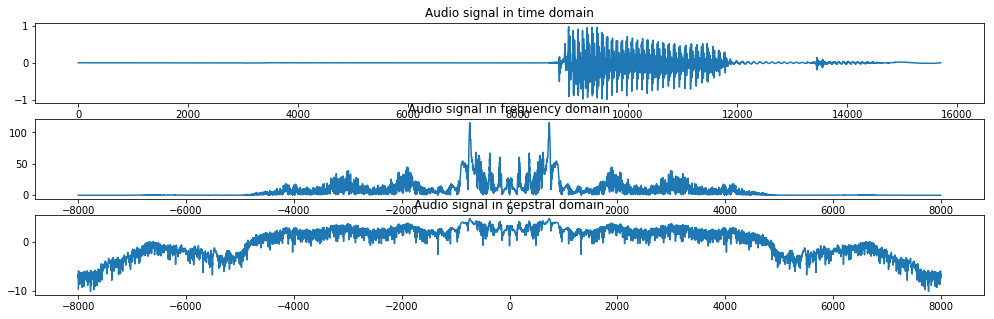

In [14]:
word = 0
def get_audio(filepath):
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
    return audio, sampling_rate

audio, sampling_rate = get_audio(features_og[('info','path')].iloc[word])

# Look at the signal in the time domain
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(audio)
ax1.set_title('Audio signal in time domain')

# Look at the signal in the frequency domain
ax2.plot(np.linspace(-sampling_rate/2,sampling_rate/2,len(audio)),np.abs(np.fft.fftshift(np.fft.fft(audio))))
ax2.set_title('Audio signal in frequency domain')

# Look at the signal in the frequency domain
ax3.plot(np.linspace(-sampling_rate/2,sampling_rate/2,len(audio)),np.log(np.abs(np.fft.fftshift(np.fft.fft(audio)))))
ax3.set_title('Audio signal in cepstral domain')

# Listen to the sample
ipd.Audio(data=audio, rate=sampling_rate)

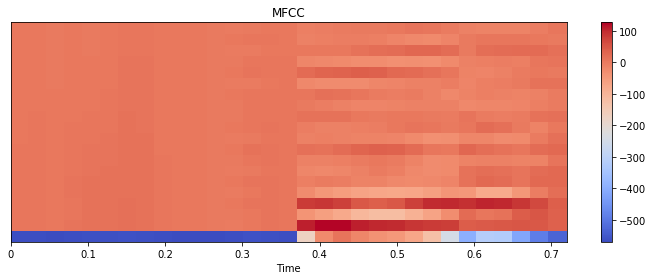

In [15]:
mfccs = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=20)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

Remark: If we only use MFCC, we dont have to dtect the beggining and end of the word-> except we want to use several Mfcc vectors

Text(0,0.5,'rmse')

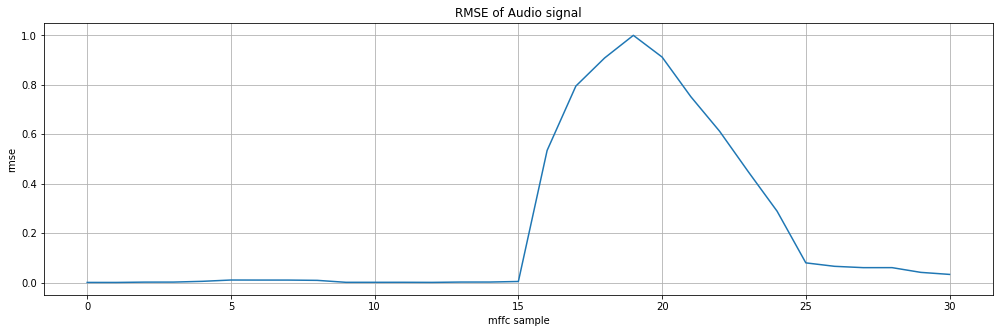

In [16]:
rmse_audio = librosa.feature.rmse(audio).reshape(-1,)
plt.plot(rmse_audio/max(rmse_audio))
plt.grid()
plt.title('RMSE of Audio signal')
plt.xlabel('mffc sample')
plt.ylabel('rmse')

Clearly we can detect the word envelop using RMSE.